In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

from torchvision.models.detection import keypointrcnn_resnet50_fpn, KeypointRCNN_ResNet50_FPN_Weights
# import albumentations as A # Library for augmentations
import os
import cv2
import json
import time
import random
import argparse
import numpy as np
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

#Very hacky fix to make matplotlib work on my pc
# import os
# os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized.

repo_dir = "c:/Users/James/git/3dGolfPoseDetection/"
save_dir = repo_dir + "/dev-nbs/saved-labels/"
downloaded_dir = repo_dir + "downloaded-data/"

### Hyperparameters
batch_size = 3

batch[0] list containing 32 tensors of shape torch.Size([3, 640, 640]):
batch[1] list containing 32 of the following:
'boxes': torch.Size([1, 4]), torch.float32
'labels': torch.Size([1]), torch.int64
'keypoints': torch.Size([1, 2, 3]), torch.float32


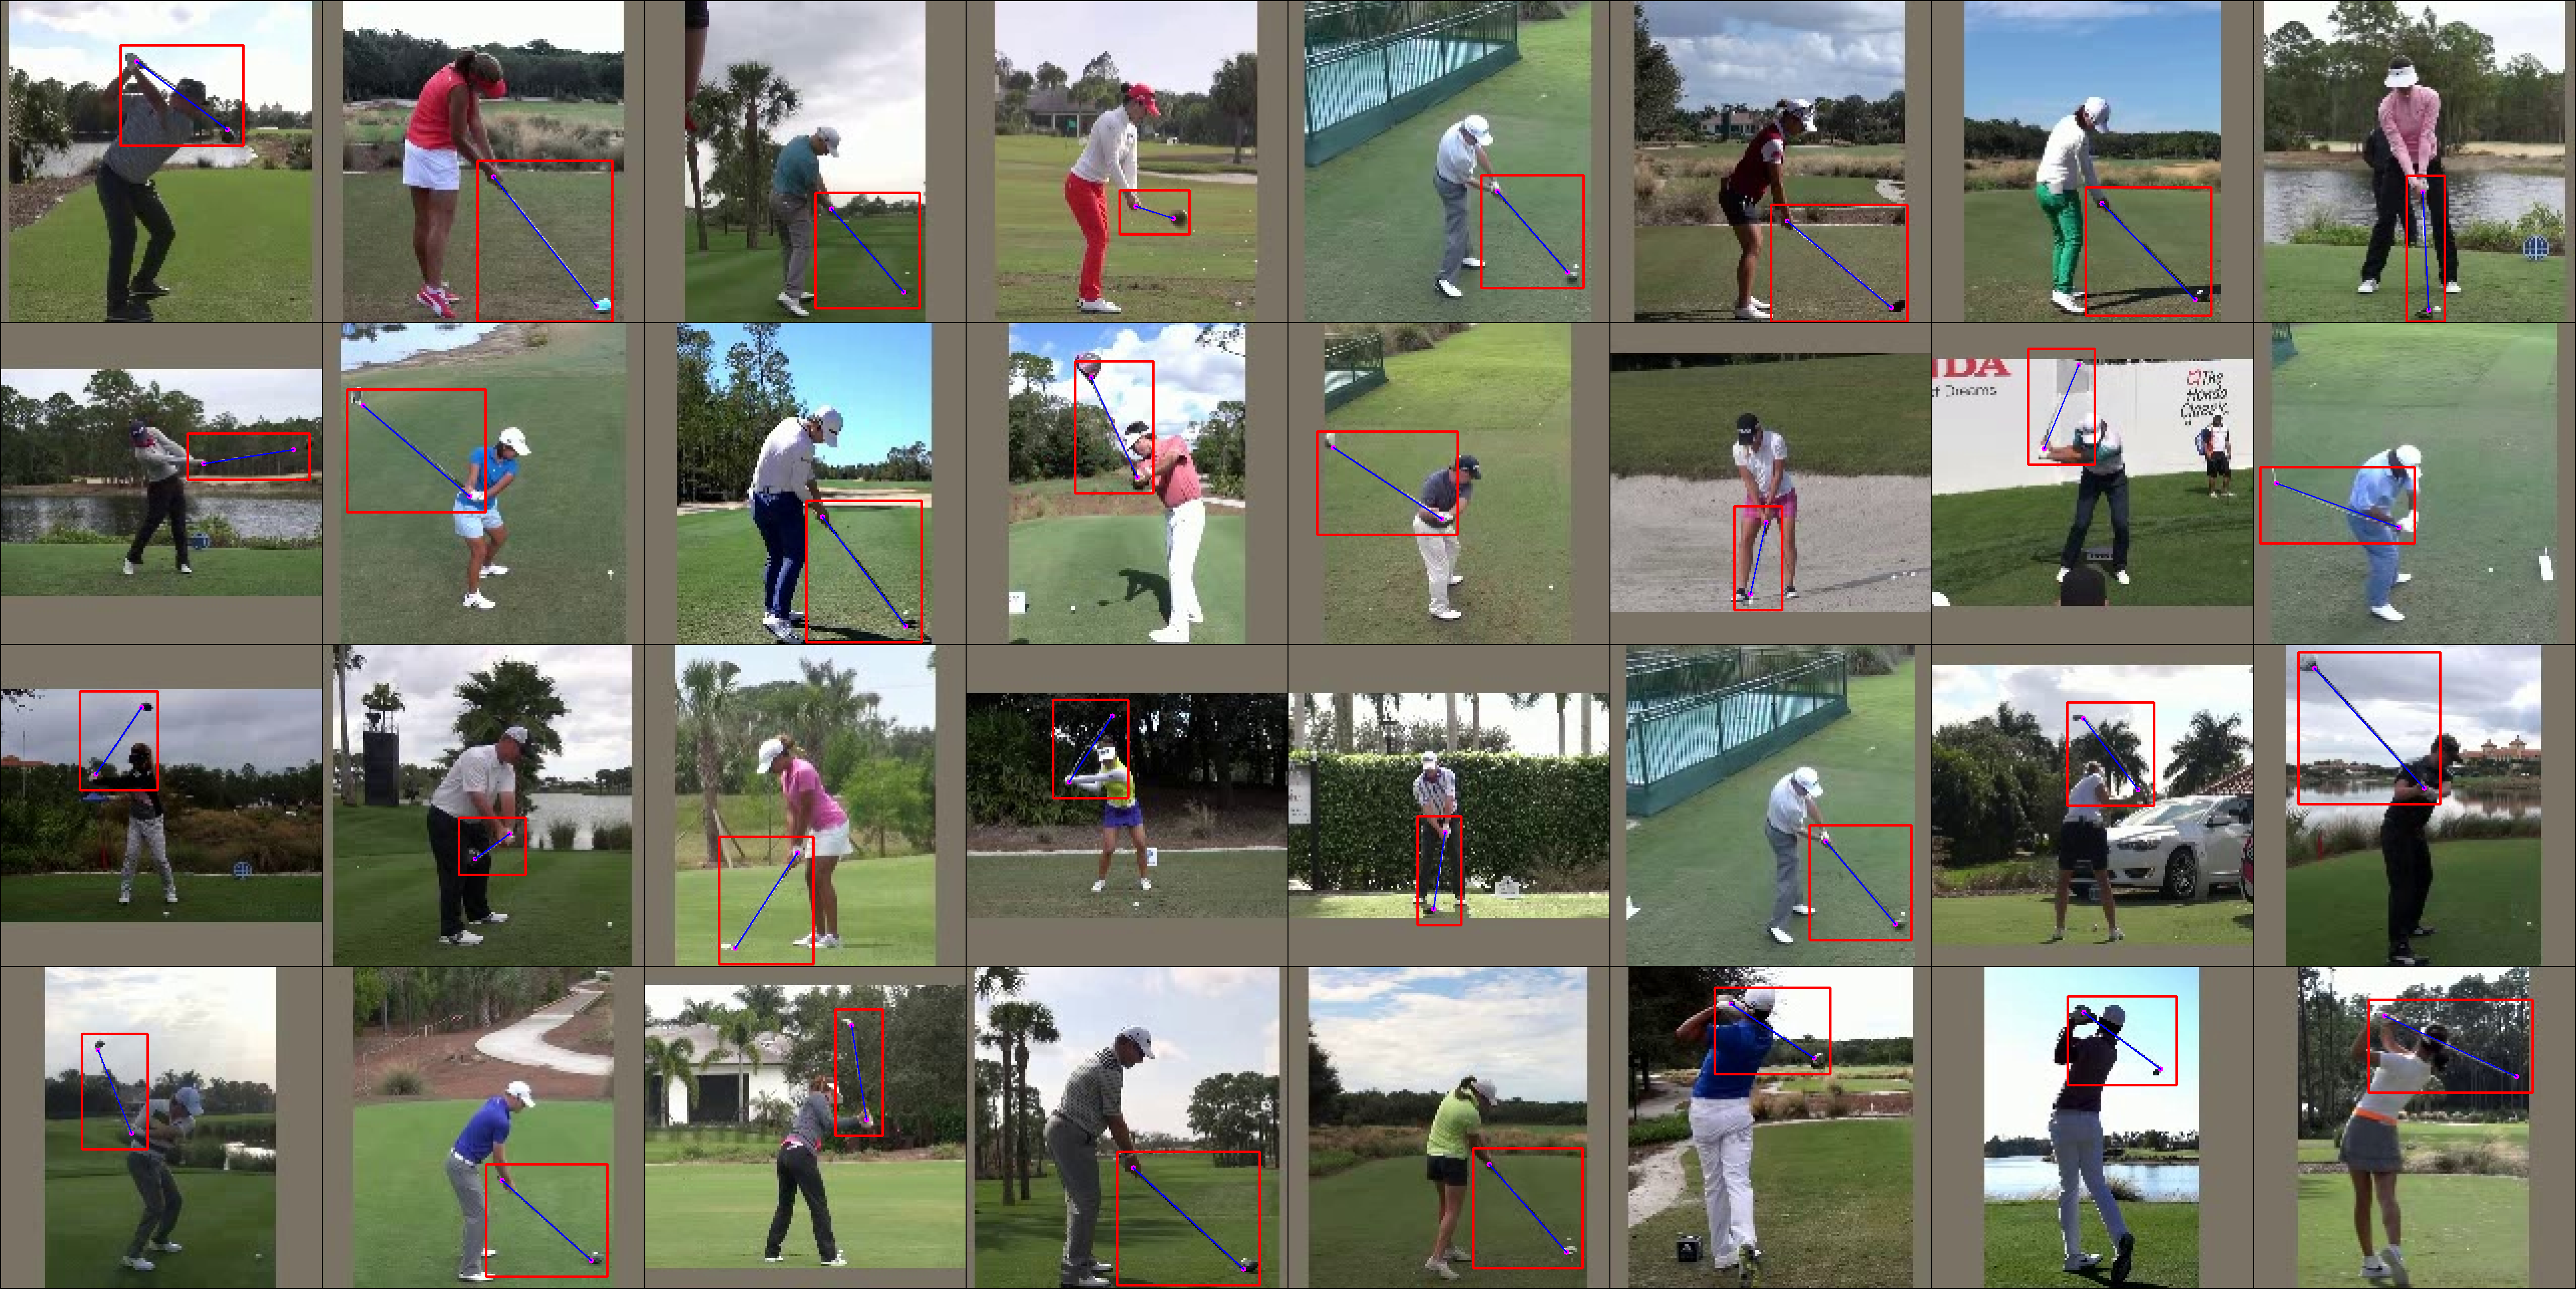

In [35]:
def label_img(img, club_coordinates, box_cords, line_width=4):
    grip, club = club_coordinates
    labelled = img.copy()
    cv2.circle(labelled, grip[:2], 5, (255,0,255), -1)
    cv2.circle(labelled, club[:2], 5, (255,0,255), -1)
    cv2.line(labelled, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(labelled, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return labelled

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, save_dir, annotate = False, resize_size = 640):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.save_dir = save_dir
        self.filenames = filenames # filenames of image locations
        self.resize_size = resize_size
        self.dtype = torch.float32
        self.img_transforms = transforms.ToTensor()
        # transforms = []
        self.annotate = annotate

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        # img_num = int(filename.split("_")[0])
        img = cv2.imread(self.save_dir+filename)
        assert img.shape[0] == img.shape[1], f"Image is not square: {img.shape} | {filename}"

        w = img.shape[0]
        r = self.resize_size / float(w)
        img = cv2.resize(img, (self.resize_size, self.resize_size), interpolation = cv2.INTER_AREA)
        all_cords = [int(x) for x in filename.split("_")[1].split("-")]
        all_cords = [int(x*r) for x in all_cords]
        grip, club, box_cords = all_cords[:2], all_cords[2:4], all_cords[4:]
        grip.append(1.)
        club.append(1.)
        if self.annotate:
            img = label_img(img, [grip, club], box_cords)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        

        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64).to(self.device)
        target["keypoints"] = torch.Tensor([grip, club]).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)
        img = Image.fromarray(img[:,:,::-1])
        img = self.img_transforms(img).to(self.device)

        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))


filenames = os.listdir(save_dir)
dataset = GolfDataset(filenames, save_dir, annotate=True, resize_size = 640)
dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=32, shuffle=False)
batch = next(iter(dataloader))

print(f"batch[0] list containing {len(batch[0])} tensors of shape {batch[0][0].shape}:")
print(f"batch[1] list containing {len(batch[1])} of the following:")
for key in batch[1][0]:
    print(f"'{key}': {batch[1][0][key].shape}, {batch[1][0][key].dtype}")

Image.fromarray((torchvision.utils.make_grid(torch.stack(batch[0],dim=0), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

In [4]:
model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
model.roi_heads.keypoint_predictor.kps_score_lowres = out

In [29]:
model.eval()
batch = next(iter(dataloader))
output = model(batch[0])
len(output), output[0]

(3,
 {'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>),
  'labels': tensor([], dtype=torch.int64),
  'scores': tensor([], grad_fn=<IndexBackward0>),
  'keypoints': tensor([], size=(0, 2, 3)),
  'keypoints_scores': tensor([], size=(0, 2))})

In [26]:
model.train()
metrics = model(*batch)
for k, v in metrics.items():
    print(f'{k}: {v}')

#count parameters
print(f'Model has {sum(p.numel() for p in model.parameters()):,} parameters')

loss_classifier: 0.20058126747608185
loss_box_reg: 0.08342474699020386
loss_keypoint: 10.361076354980469
loss_objectness: 0.07220228016376495
loss_rpn_box_reg: 0.002814966021105647
Model has 59,014,363 parameters


In [34]:
metrics.keys()

dict_keys(['loss_classifier', 'loss_box_reg', 'loss_keypoint', 'loss_objectness', 'loss_rpn_box_reg'])

In [ ]:
{'boxes': tensor([[196.7647, 161.6837, 355.8739, 574.6700],
         [458.2339, 256.9807, 464.1445, 272.8716],
         [455.7396, 254.4996, 464.2141, 277.8954],
         [445.8767, 248.3218, 458.3318, 281.7727],
         [307.4313, 191.0459, 333.5754, 257.4498],
         [111.1199,  98.3755, 391.9510, 627.4518]], grad_fn=<StackBackward0>),
 'labels': tensor([1, 1, 1, 1, 1, 1]),
 'scores': tensor([0.2716, 0.0919, 0.0822, 0.0718, 0.0710, 0.0633],
        grad_fn=<IndexBackward0>),
 'keypoints': tensor([[[197.1644, 434.4783,   1.0000],
          [318.6951, 162.8820,   1.0000]],
 
         [[463.7751, 257.3779,   1.0000],
          [463.0362, 257.3779,   1.0000]],
 
         [[463.8289, 254.8896,   1.0000],
          [460.7472, 254.8896,   1.0000]],
 
         [[447.0443, 248.7200,   1.0000],
          [454.0504, 248.7200,   1.0000]],
 
         [[332.3870, 191.4412,   1.0000],
          [322.0879, 191.4412,   1.0000]],
 
         [[112.3166, 485.5922,   1.0000],
          [196.8851,  99.5743,   1.0000]]], grad_fn=<CopySlices>),
 'keypoints_scores': tensor([[3.8548, 6.2852],
         [0.3757, 3.7921],
         [1.6036, 4.4125],
         [1.6148, 5.0556],
         [2.0451, 5.4284],
         [5.8937, 7.2045]], grad_fn=<CopySlices>)}

In [48]:
def label_img(img, club_coordinates, box_cords, line_width=4):
    grip, club = club_coordinates
    labelled = img.copy()
    cv2.circle(labelled, grip[:2], 5, (255,0,255), -1)
    cv2.circle(labelled, club[:2], 5, (255,0,255), -1)
    cv2.line(labelled, club[:2], grip[:2], (255, 0, 0), 2)
    cv2.rectangle(labelled, box_cords[:2], box_cords[2:], (0, 0, 255), line_width)
    return labelled

class GolfDataset(torch.utils.data.Dataset):
    def __init__(self, filenames, save_dir, annotate = False, device = torch.device("cpu")):
        self.device = device
        self.save_dir = save_dir
        self.filenames = filenames # filenames of image locations
        self.dtype = torch.float32
        self.img_transforms = transforms.ToTensor()
        self.annotate = annotate

    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, idx):
        filename = self.filenames[idx]
        # img_num = int(filename.split("_")[0])
        img = cv2.imread(self.save_dir+filename)
        assert img.shape[0] == img.shape[1], f"Image is not square: {img.shape} | {filename}"

        w = img.shape[0]
        r = self.resize_size / float(w)
        img = cv2.resize(img, (self.resize_size, self.resize_size), interpolation = cv2.INTER_AREA)
        all_cords = [int(x) for x in filename.split("_")[1].split("-")]
        all_cords = [int(x*r) for x in all_cords]
        grip, club, box_cords = all_cords[:2], all_cords[2:4], all_cords[4:]
        grip.append(1.)
        club.append(1.)
        if self.annotate:
            img = label_img(img, [grip, club], box_cords)

        # During training, the model expects both the input tensors and targets (list of dictionary), containing:
        # boxes (FloatTensor[N, 4]): the ground-truth boxes in [x1, y1, x2, y2] format, with 0 <= x1 < x2 <= W and 0 <= y1 < y2 <= H.
        # labels (Int64Tensor[N]): the class label for each ground-truth box
        # keypoints (FloatTensor[N, K, 3]): the K keypoints location for each of the N instances, in the format [x, y, visibility], where visibility=0 means that the keypoint is not visible.
        

        target = {}
        target["boxes"] = torch.Tensor(box_cords).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)
        target["labels"] = torch.Tensor(torch.ones(1)).type(torch.int64).to(self.device)
        target["keypoints"] = torch.Tensor([grip, club]).unsqueeze(dim=0).type(torch.FloatTensor).to(self.device)
        img = Image.fromarray(img[:,:,::-1])
        img = self.img_transforms(img).to(self.device)

        return img, target
    
def collate_fn(batch):
    return tuple(zip(*batch))

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
filenames = os.listdir(save_dir)
dataset = GolfDataset(filenames, save_dir, annotate=True, device=device) # Leave annotated for first test, should easily learn this
dataset[0]

AttributeError: 'GolfDataset' object has no attribute 'resize_size'

In [ ]:
#Open in cv2. has self.resize_size as a attribute.
#Input images for training are already 800x800 so don't need to resize. Use PIL to open instead - shortens the code alot

In [ ]:
dataloader = torch.utils.data.DataLoader(dataset, collate_fn=collate_fn, batch_size=batch_size, shuffle=True)

batch = next(iter(dataloader))

print(f"batch[0] list containing {len(batch[0])} tensors of shape {batch[0][0].shape}:")
print(f"batch[1] list containing {len(batch[1])} of the following:")
for key in batch[1][0]:
    print(f"'{key}': {batch[1][0][key].shape}, {batch[1][0][key].dtype}")

Image.fromarray((torchvision.utils.make_grid(torch.stack(batch[0],dim=0), padding=2, normalize=True).permute(1,2,0).numpy()*255).astype(np.uint8))

In [46]:
############### Full training loop ###############drop_last=False

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

num_epochs = 10
lr = 0.005
weight_decay = 0.0005
batch_size = 2


model = keypointrcnn_resnet50_fpn(weights=KeypointRCNN_ResNet50_FPN_Weights.DEFAULT)
model.eval()
out = nn.ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
model.roi_heads.keypoint_predictor.kps_score_lowres = out
model = model.to(device)

#freeze parameters in backbone
for param in model.backbone.parameters():
    param.requires_grad = False

params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=lr, weight_decay=weight_decay)

# learning rate schedulers
lr_scheduler_epochs = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)
lr_scheduler = None


model.train()
epoch_loss = []
for epoch in range(num_epochs):
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(dataloader) - 1)
        lr_scheduler_warmup = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=warmup_factor, total_iters=warmup_iters)

    running_loss = 0.0
    for batch_idx, batch in enumerate(dataloader):
        # losses_dict = model(*batch)
        # total_loss = sum([losses_dict[key] for key in ['loss_classifier', 'loss_box_reg', 'loss_objectness', 'loss_rpn_box_reg']]) #  'loss_keypoint'
        # epoch_loss.append(total_loss.item())

        # optimizer.zero_grad()
        # total_loss.backward()
        # optimizer.step()

        if epoch == 0:
            lr_scheduler_warmup.step()

        if batch_idx % 10 == 0:
            print(batch_idx, get_lr(optimizer))

    lr_scheduler_epochs.step()


    # train_one_epoch(model, optimizer, dataloader, device, epoch, print_freq=10)
    # evaluate(model, data_loader_test, device=device)

AttributeError: 'GolfDataset' object has no attribute 'resize_size'

In [ ]:
optimizer

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger

In [ ]:
import datetime
import errno
import os
import time
from collections import defaultdict, deque

import torch
import torch.distributed as dist

class SmoothedValue:
    """Track a series of values and provide access to smoothed values over a
    window or the global series average.
    """

    def __init__(self, window_size=20, fmt=None):
        if fmt is None:
            fmt = "{median:.4f} ({global_avg:.4f})"
        self.deque = deque(maxlen=window_size)
        self.total = 0.0
        self.count = 0
        self.fmt = fmt

    def update(self, value, n=1):
        self.deque.append(value)
        self.count += n
        self.total += value * n

    def synchronize_between_processes(self):
        """
        Warning: does not synchronize the deque!
        """
        if not is_dist_avail_and_initialized():
            return
        t = torch.tensor([self.count, self.total], dtype=torch.float64, device="cuda")
        dist.barrier()
        dist.all_reduce(t)
        t = t.tolist()
        self.count = int(t[0])
        self.total = t[1]

    @property
    def median(self):
        d = torch.tensor(list(self.deque))
        return d.median().item()

    @property
    def avg(self):
        d = torch.tensor(list(self.deque), dtype=torch.float32)
        return d.mean().item()

    @property
    def global_avg(self):
        return self.total / self.count

    @property
    def max(self):
        return max(self.deque)

    @property
    def value(self):
        return self.deque[-1]

    def __str__(self):
        return self.fmt.format(
            median=self.median, avg=self.avg, global_avg=self.global_avg, max=self.max, value=self.value
        )
def reduce_dict(input_dict, average=True):
    """
    Args:
        input_dict (dict): all the values will be reduced
        average (bool): whether to do average or sum
    Reduce the values in the dictionary from all processes so that all processes
    have the averaged results. Returns a dict with the same fields as
    input_dict, after reduction.
    """
    world_size = get_world_size()
    if world_size < 2:
        return input_dict
    with torch.inference_mode():
        names = []
        values = []
        # sort the keys so that they are consistent across processes
        for k in sorted(input_dict.keys()):
            names.append(k)
            values.append(input_dict[k])
        values = torch.stack(values, dim=0)
        dist.all_reduce(values)
        if average:
            values /= world_size
        reduced_dict = {k: v for k, v in zip(names, values)}
    return reduced_dict


class MetricLogger:
    def __init__(self, delimiter="\t"):
        self.meters = defaultdict(SmoothedValue)
        self.delimiter = delimiter

    def update(self, **kwargs):
        for k, v in kwargs.items():
            if isinstance(v, torch.Tensor):
                v = v.item()
            assert isinstance(v, (float, int))
            self.meters[k].update(v)

    def __getattr__(self, attr):
        if attr in self.meters:
            return self.meters[attr]
        if attr in self.__dict__:
            return self.__dict__[attr]
        raise AttributeError(f"'{type(self).__name__}' object has no attribute '{attr}'")

    def __str__(self):
        loss_str = []
        for name, meter in self.meters.items():
            loss_str.append(f"{name}: {str(meter)}")
        return self.delimiter.join(loss_str)

    def synchronize_between_processes(self):
        for meter in self.meters.values():
            meter.synchronize_between_processes()

    def add_meter(self, name, meter):
        self.meters[name] = meter

    def log_every(self, iterable, print_freq, header=None):
        i = 0
        if not header:
            header = ""
        start_time = time.time()
        end = time.time()
        iter_time = SmoothedValue(fmt="{avg:.4f}")
        data_time = SmoothedValue(fmt="{avg:.4f}")
        space_fmt = ":" + str(len(str(len(iterable)))) + "d"
        if torch.cuda.is_available():
            log_msg = self.delimiter.join(
                [
                    header,
                    "[{0" + space_fmt + "}/{1}]",
                    "eta: {eta}",
                    "{meters}",
                    "time: {time}",
                    "data: {data}",
                    "max mem: {memory:.0f}",
                ]
            )
        else:
            log_msg = self.delimiter.join(
                [header, "[{0" + space_fmt + "}/{1}]", "eta: {eta}", "{meters}", "time: {time}", "data: {data}"]
            )
        MB = 1024.0 * 1024.0
        for obj in iterable:
            data_time.update(time.time() - end)
            yield obj
            iter_time.update(time.time() - end)
            if i % print_freq == 0 or i == len(iterable) - 1:
                eta_seconds = iter_time.global_avg * (len(iterable) - i)
                eta_string = str(datetime.timedelta(seconds=int(eta_seconds)))
                if torch.cuda.is_available():
                    print(
                        log_msg.format(
                            i,
                            len(iterable),
                            eta=eta_string,
                            meters=str(self),
                            time=str(iter_time),
                            data=str(data_time),
                            memory=torch.cuda.max_memory_allocated() / MB,
                        )
                    )
                else:
                    print(
                        log_msg.format(
                            i, len(iterable), eta=eta_string, meters=str(self), time=str(iter_time), data=str(data_time)
                        )
                    )
            i += 1
            end = time.time()
        total_time = time.time() - start_time
        total_time_str = str(datetime.timedelta(seconds=int(total_time)))
        print(f"{header} Total time: {total_time_str} ({total_time / len(iterable):.4f} s / it)")





In [6]:
model

KeypointRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.

In [12]:
model.transform

GeneralizedRCNNTransform(
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    Resize(min_size=(640, 672, 704, 736, 768, 800), max_size=1333, mode='bilinear')
)

In [13]:
model.backbone

BackboneWithFPN(
  (body): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): FrozenBatchNorm2d(64, eps=0.0)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): FrozenBatchNorm2d(64, eps=0.0)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): FrozenBatchNorm2d(64, eps=0.0)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): FrozenBatchNorm2d(256, eps=0.0)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): FrozenBatchNorm2d(256, eps=0.0)
        )
      )
      (1): Bottleneck(
        (conv1): C

In [14]:
model.backbone.fpn

FeaturePyramidNetwork(
  (inner_blocks): ModuleList(
    (0): Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (1): Conv2dNormActivation(
      (0): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (2): Conv2dNormActivation(
      (0): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    )
    (3): Conv2dNormActivation(
      (0): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    )
  )
  (layer_blocks): ModuleList(
    (0-3): 4 x Conv2dNormActivation(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (extra_blocks): LastLevelMaxPool()
)

In [15]:
model.rpn

RegionProposalNetwork(
  (anchor_generator): AnchorGenerator()
  (head): RPNHead(
    (conv): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU(inplace=True)
      )
    )
    (cls_logits): Conv2d(256, 3, kernel_size=(1, 1), stride=(1, 1))
    (bbox_pred): Conv2d(256, 12, kernel_size=(1, 1), stride=(1, 1))
  )
)

In [16]:
model.roi_heads

RoIHeads(
  (box_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)
  (box_head): TwoMLPHead(
    (fc6): Linear(in_features=12544, out_features=1024, bias=True)
    (fc7): Linear(in_features=1024, out_features=1024, bias=True)
  )
  (box_predictor): FastRCNNPredictor(
    (cls_score): Linear(in_features=1024, out_features=2, bias=True)
    (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
  )
  (keypoint_roi_pool): MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)
  (keypoint_head): KeypointRCNNHeads(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padd

In [17]:
model.roi_heads.box_roi_pool

MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(7, 7), sampling_ratio=2)

In [18]:
model.roi_heads.box_head

TwoMLPHead(
  (fc6): Linear(in_features=12544, out_features=1024, bias=True)
  (fc7): Linear(in_features=1024, out_features=1024, bias=True)
)

In [19]:
model.roi_heads.box_predictor

FastRCNNPredictor(
  (cls_score): Linear(in_features=1024, out_features=2, bias=True)
  (bbox_pred): Linear(in_features=1024, out_features=8, bias=True)
)

In [20]:
model.roi_heads.keypoint_roi_pool

MultiScaleRoIAlign(featmap_names=['0', '1', '2', '3'], output_size=(14, 14), sampling_ratio=2)

In [21]:
model.roi_heads.keypoint_head

KeypointRCNNHeads(
  (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU(inplace=True)
  (6): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): ReLU(inplace=True)
  (8): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): ReLU(inplace=True)
  (10): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
)

In [22]:
model.roi_heads.keypoint_predictor

KeypointRCNNPredictor(
  (kps_score_lowres): ConvTranspose2d(512, 2, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)